### Investigating network similarity for the analysis of fish behaviour

In [68]:
import os
import numpy as np
import netrd, networkx as nx
import statistics
import pandas as pd
import itertools
import matplotlib.pyplot as plt


"""
lists directory, each element with its full path
"""
def listdir_fullpath(d):
    return [os.path.join(d, f) for f in os.listdir(d)]


"""
Returns Jaccard distance for weighted directed networks 
"""
def weighted_jaccard(g1,g2):
    e1 = set(g1.edges)
    e2 = set(g2.edges)
    cup = set.union(e1, e2)
    cap = set.intersection(e1, e2)

    #if edge weights are different only add the relative accordance
    relative_sum = 0
    for edge in cap:
        w1 = g1.get_edge_data(edge[0], edge[1])["label"]
        w2 = g2.get_edge_data(edge[0], edge[1])["label"]
        if w1 > w2:
            relative_sum = relative_sum + (w2 / w1)
        elif w2 > w1:
            relative_sum = relative_sum + (w1 / w2)
        else:
            relative_sum = relative_sum +1

    dist = 1 - relative_sum / len(cup)
    return dist


#lists with the files
oce_bvr = listdir_fullpath("/Users/nicol/Desktop/bachelorthesis/data/normalized/ocellatus-behaviours/")
mul_bvr = listdir_fullpath("/Users/nicol/Desktop/bachelorthesis/data/normalized/multi-behaviours/")
tem_bvr = listdir_fullpath("/Users/nicol/Desktop/bachelorthesis/data/normalized/tempo-behaviours/")

oce_ctg = listdir_fullpath("/Users/nicol/Desktop/bachelorthesis/data/normalized/ocellatus-categories/")
mul_ctg = listdir_fullpath("/Users/nicol/Desktop/bachelorthesis/data/normalized/multi-categories/")
tem_ctg = listdir_fullpath("/Users/nicol/Desktop/bachelorthesis/data/normalized/tempo-categories/")

behaviours = [oce_bvr, mul_bvr, tem_bvr]
categories = [oce_ctg, mul_ctg, tem_ctg]

# list with algorithms to apply
distance_algs =  [netrd.distance.Hamming(),
                  netrd.distance.Frobenius(),
                  netrd.distance.PortraitDivergence(),
                  netrd.distance.JaccardDistance(), 
                  'weighted_jaccard',
]
#distance_algs = [netrd.distance.DeltaCon()]
#names 
algs = ['hamming', 'frobenius', 'portrait_divergence', 
        'jaccard_distance', 'weighted_jaccard']
#algs = ['deltacon']
#istance_algs = [netrd.distance.PortraitDivergence()]
same_nodes_algs = ['hamming', 'frobenius', 'deltacon']

results= []
df = pd.DataFrame(columns=['alg', 'data1', 'data2', 'results'])
general_df = pd.DataFrame(columns=['alg', 'data', 'type', 'results'])

for alg in distance_algs:
    if alg == 'weighted_jaccard':
        alg_name = alg
    else:
        alg_name = str(alg).split(".")[2]
    print(alg_name)
    
    #lists for specieal results
    bhvr_across_species = []
    bhvr_within_species = []
    cat_across_species = []
    cat_within_species = []
    
    #BEHAVIOURS PAIRWISE
    for data1, data2 in itertools.combinations(behaviours, 2):
        #folder names for adding in dataframe
        folder1 = str(data1).split("/")[7]
        folder2 = str(data2).split("/")[7]
        #compare each folder with each other
        for a in data1:
            for b in data2:

                #read gpickles into networkx
                g1 = nx.read_gpickle(a)
                g2 = nx.read_gpickle(b)
                
                for edge in g1.edges:
                    weight = g1.get_edge_data(edge[0],edge[1])['label']
                    g1[edge[0]][edge[1]]['weight'] = weight
                    
                for edge in g2.edges:
                    weight = g2.get_edge_data(edge[0],edge[1])['label']
                    g2[edge[0]][edge[1]]['weight'] = weight

                # if alg requires same nodeset, add nodes
                if alg_name in same_nodes_algs:    
                    not_in_g1 = np.setdiff1d(g2.nodes(),g1.nodes())
                    g1.add_nodes_from(not_in_g1)
                    not_in_g2 = np.setdiff1d(g1.nodes(),g2.nodes())
                    g2.add_nodes_from(not_in_g2)

                #calculate and append results
                if alg_name == 'weighted_jaccard':
                    results.append(weighted_jaccard(g1,g2))
                else:
                    dist = alg
                    d = dist.dist(g1, g2)
                    results.append(d)
               


        #calculate statistics and append to across species list
        df.loc[len(df.index)] = [alg_name,folder1, folder2, results]
        bhvr_across_species.extend(results)
        results = []
        
    #add row for behaviours across species
    general_df.loc[len(df.index)] = [alg_name, 'across species', 'behaviours', bhvr_across_species]    
        
        
    #CATEGORIES PAIRWISE
    for data1, data2 in itertools.combinations(categories, 2):
        #folder names for adding in dataframe
        folder1 = str(data1).split("/")[7]
        folder2 = str(data2).split("/")[7]
        #compare each folder with each other
        for a in data1:
            for b in data2:

                #read gpickles into networkx
                g1 = nx.read_gpickle(a)
                g2 = nx.read_gpickle(b)

                # if alg requires same nodeset, add nodes
                if alg_name in same_nodes_algs:    
                    not_in_g1 = np.setdiff1d(g2.nodes(),g1.nodes())
                    g1.add_nodes_from(not_in_g1)
                    not_in_g2 = np.setdiff1d(g1.nodes(),g2.nodes())
                    g2.add_nodes_from(not_in_g2)

               
                #calculate and append results
                if alg_name == 'weighted_jaccard':
                    results.append(weighted_jaccard(g1,g2))
                else:
                    dist = alg
                    d = dist.dist(g1, g2)
                    results.append(d)
                
        #calculate statistics
        df.loc[len(df.index)] = [alg_name,folder1, folder2, results]
        cat_across_species.extend(results)
        results = []
        
    #add row for behaviours across species
    general_df.loc[len(df.index)] = [alg_name, 'across species', 'behavioural category', cat_across_species]  
        
    #CATEGORIES SINGLE
    for data in categories:
        #folder names for adding in dataframe
        folder1 = str(data).split("/")[7]
        folder2 = str(data).split("/")[7]
        #compare each folder with each other
        for a,b in itertools.combinations(data, 2):

                #read gpickles into networkx
                g1 = nx.read_gpickle(a)
                g2 = nx.read_gpickle(b)

                # if alg requires same nodeset, add nodes
                if alg_name in same_nodes_algs:    
                    not_in_g1 = np.setdiff1d(g2.nodes(),g1.nodes())
                    g1.add_nodes_from(not_in_g1)
                    not_in_g2 = np.setdiff1d(g1.nodes(),g2.nodes())
                    g2.add_nodes_from(not_in_g2)

                
                #calculate and append results
                if alg_name == 'weighted_jaccard':
                    results.append(weighted_jaccard(g1,g2))
                else:
                    dist = alg
                    d = dist.dist(g1, g2)
                    results.append(d)

        #calculate statistics
        df.loc[len(df.index)] = [alg_name,folder1, folder2, results]
        cat_within_species.extend(results)
        results = []
        
    #add row for behaviours across species
    general_df.loc[len(df.index)] = [alg_name, 'within species', 'behavioural category', cat_within_species]  
        
        
    #BEHAVIOURS SINGLE
    for data in behaviours:
        #folder names for adding in dataframe
        folder1 = str(data).split("/")[7]
        folder2 = str(data).split("/")[7]
        #compare each folder with each other
        for a,b in itertools.combinations(data, 2):

                #read gpickles into networkx
                g1 = nx.read_gpickle(a)
                g2 = nx.read_gpickle(b)

                # if alg requires same nodeset, add nodes
                if alg_name in same_nodes_algs:    
                    not_in_g1 = np.setdiff1d(g2.nodes(),g1.nodes())
                    g1.add_nodes_from(not_in_g1)
                    not_in_g2 = np.setdiff1d(g1.nodes(),g2.nodes())
                    g2.add_nodes_from(not_in_g2)

               
                #calculate and append results
                if alg_name == 'weighted_jaccard':
                    results.append(weighted_jaccard(g1,g2))
                else:
                    dist = alg
                    d = dist.dist(g1, g2)
                    results.append(d)

        #calculate statistics
        df.loc[len(df.index)] = [alg_name,folder1, folder2, results]
        bhvr_within_species.extend(results)
        results = []
        
    #add row for behaviours across species
    general_df.loc[len(df.index)] = [alg_name, 'within species', 'behaviours', bhvr_within_species] 


hamming
frobenius
portrait_divergence
jaccard_distance
weighted_jaccard


In [69]:
df

,alg,data1,data2,results
0,hamming,ocellatus-behaviours,multi-behaviours,"[0.1575, 0.16942148760330578, 0.15, 0.20181405..."
1,hamming,ocellatus-behaviours,tempo-behaviours,"[0.14756944444444445, 0.1275, 0.095, 0.145, 0...."
2,hamming,multi-behaviours,tempo-behaviours,"[0.23129251700680273, 0.27555555555555555, 0.2..."
3,hamming,ocellatus-categories,multi-categories,"[0.25, 0.359375, 0.3055555555555556, 0.3333333..."
4,hamming,ocellatus-categories,tempo-categories,"[0.421875, 0.2777777777777778, 0.2777777777777..."
5,hamming,multi-categories,tempo-categories,"[0.34375, 0.1388888888888889, 0.30555555555555..."
6,hamming,ocellatus-categories,ocellatus-categories,"[0.32, 0.4, 0.25, 0.44, 0.48, 0.4, 0.32, 0.4, ..."
7,hamming,multi-categories,multi-categories,"[0.3125, 0.2777777777777778, 0.194444444444444..."
8,hamming,tempo-categories,tempo-categories,"[0.359375, 0.328125, 0.4375, 0.277777777777777..."
9,hamming,ocellatus-behaviours,ocellatus-behaviours,"[0.21453287197231835, 0.13019390581717452, 0.1..."


In [70]:
# add new column 'type' and remove type from data-columns
df['type'] = df.data1

#changing type 
type_mapping = [
    (df['type'] == 'multi-categories', 'behavioural category'),
    (df['type'] == 'tempo-categories', 'behavioural category'),
    (df['type'] == 'ocellatus-categories', 'behavioural category'),
    
    (df['type'] == 'ocellatus-behaviours', 'behaviour'),
    (df['type'] == 'multi-behaviours', 'behaviour'),
    (df['type'] == 'tempo-behaviours', 'behaviour'),
]
condlist = [item[0] for item in type_mapping]
choicelist = [item[1] for item in type_mapping]


df['type'] = np.select(condlist, choicelist)

#changing data column
data1_mapping = [
    (df['data1'] == 'multi-categories', 'multi'),
    (df['data1'] == 'tempo-categories', 'tempo'),
    (df['data1'] == 'ocellatus-categories', 'oclts'),
    
    (df['data1'] == 'ocellatus-behaviours', 'oclts'),
    (df['data1'] == 'multi-behaviours', 'multi'),
    (df['data1'] == 'tempo-behaviours', 'tempo'),
]
condlist = [item[0] for item in data1_mapping]
choicelist = [item[1] for item in data1_mapping]


df['data1'] = np.select(condlist, choicelist)

#changing data2 column
data1_mapping = [
    (df['data2'] == 'multi-categories', 'multi'),
    (df['data2'] == 'tempo-categories', 'tempo'),
    (df['data2'] == 'ocellatus-categories', 'oclts'),
    
    (df['data2'] == 'ocellatus-behaviours', 'oclts'),
    (df['data2'] == 'multi-behaviours', 'multi'),
    (df['data2'] == 'tempo-behaviours', 'tempo'),
]
condlist = [item[0] for item in data1_mapping]
choicelist = [item[1] for item in data1_mapping]


df['data2'] = np.select(condlist, choicelist)
df

,alg,data1,data2,results,type
0,hamming,oclts,multi,"[0.1575, 0.16942148760330578, 0.15, 0.20181405...",behaviour
1,hamming,oclts,tempo,"[0.14756944444444445, 0.1275, 0.095, 0.145, 0....",behaviour
2,hamming,multi,tempo,"[0.23129251700680273, 0.27555555555555555, 0.2...",behaviour
3,hamming,oclts,multi,"[0.25, 0.359375, 0.3055555555555556, 0.3333333...",behavioural category
4,hamming,oclts,tempo,"[0.421875, 0.2777777777777778, 0.2777777777777...",behavioural category
5,hamming,multi,tempo,"[0.34375, 0.1388888888888889, 0.30555555555555...",behavioural category
6,hamming,oclts,oclts,"[0.32, 0.4, 0.25, 0.44, 0.48, 0.4, 0.32, 0.4, ...",behavioural category
7,hamming,multi,multi,"[0.3125, 0.2777777777777778, 0.194444444444444...",behavioural category
8,hamming,tempo,tempo,"[0.359375, 0.328125, 0.4375, 0.277777777777777...",behavioural category
9,hamming,oclts,oclts,"[0.21453287197231835, 0.13019390581717452, 0.1...",behaviour


### plots
erste zeile ist titel, 
2te (2te und 3te) sind x-achsenabschnitte,
median,max,min sind spritzen-y-gemappt


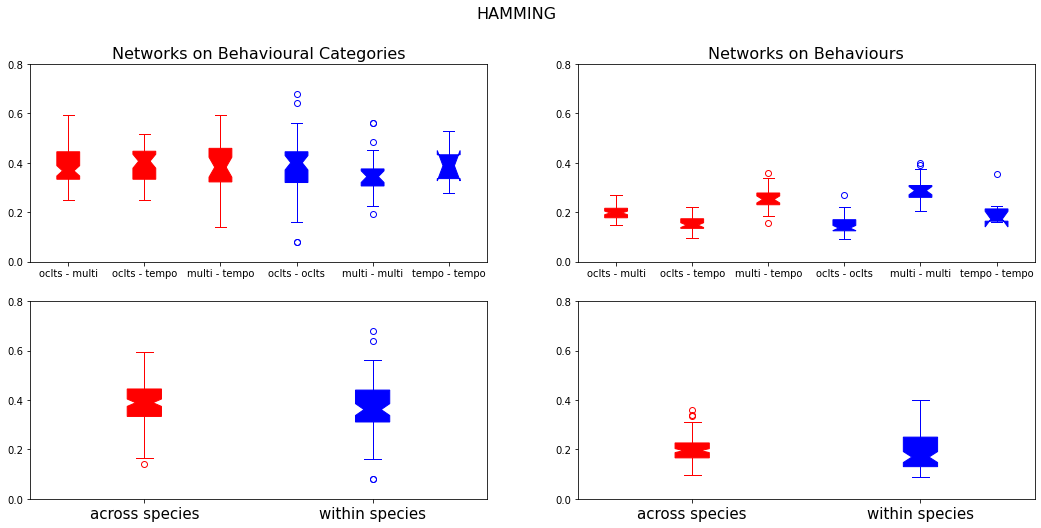

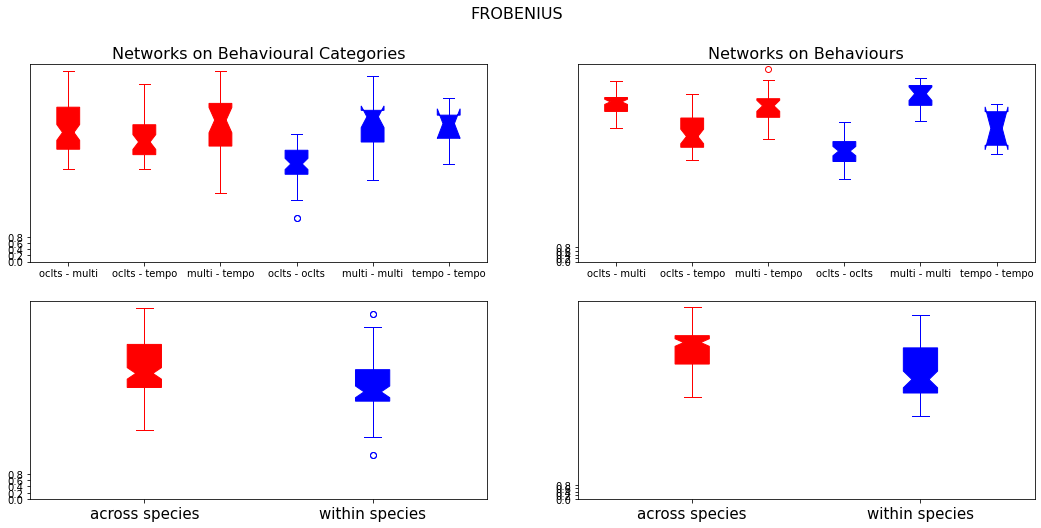

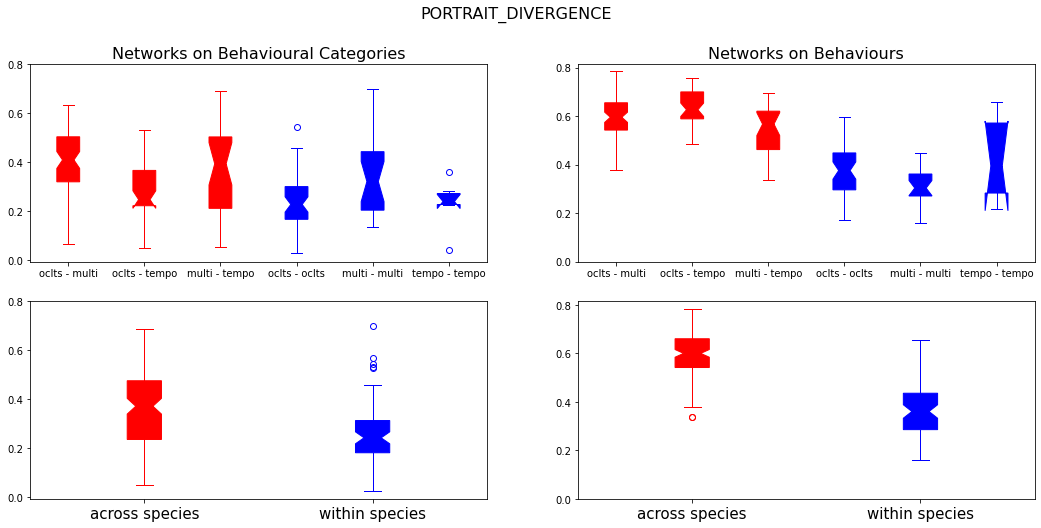

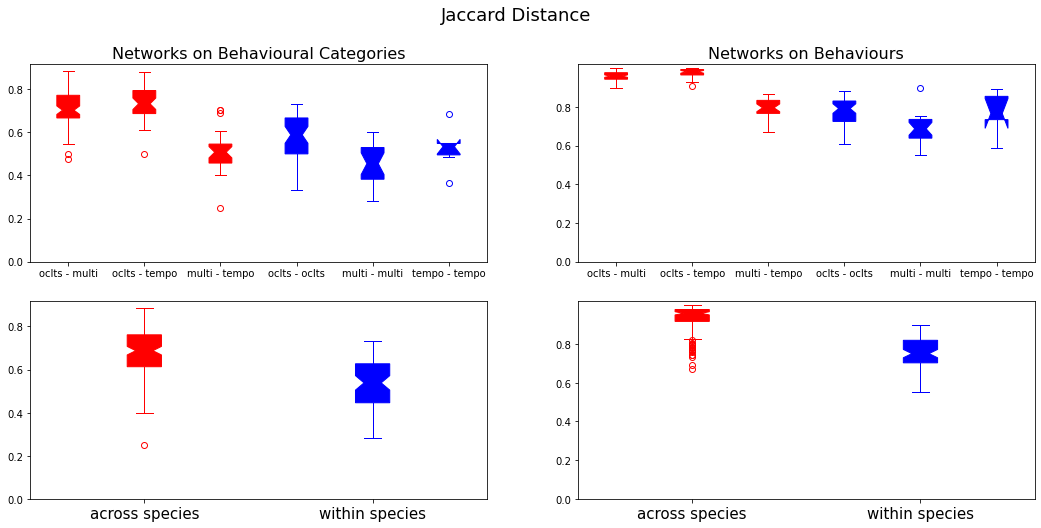

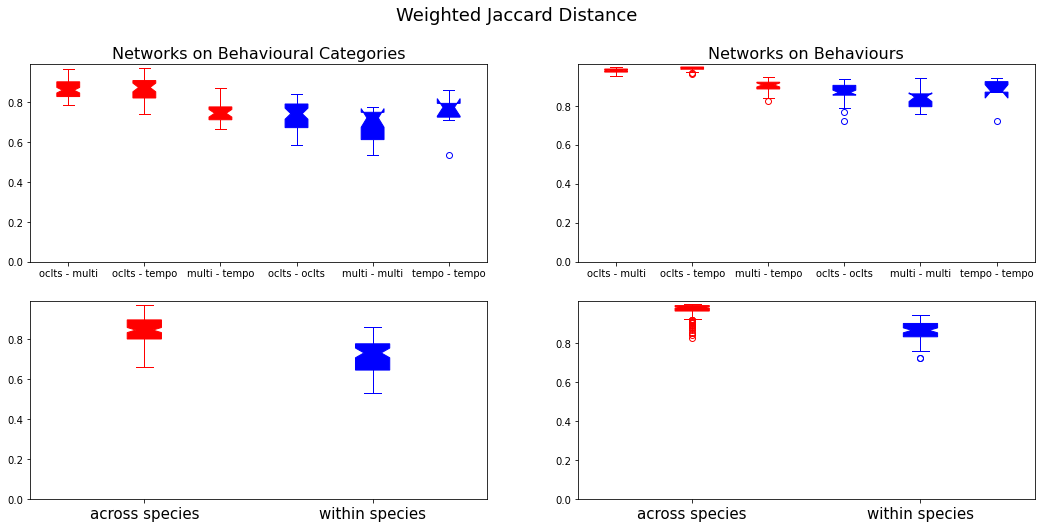

In [91]:
import matplotlib.patches as mpatches


for alg in algs:
    alg_df = df[df.alg == alg]
    
    #behavioural category data gen
    bhvr_df = alg_df[alg_df.type == 'behavioural category']
    data = []
    labels = []
    i=0
    while (i < len(bhvr_df)):
        data.append(bhvr_df.iloc[i]['results'])
        labels.append(bhvr_df.iloc[i]['data1'] + " - " +bhvr_df.iloc[i]['data2'])
        i = i+1
        
    #behaviour data gen
    bhvr_df = alg_df[alg_df.type == 'behaviour']
    data_bhvr = []
    labels_bhvr = []
    i=0
    while (i < len(bhvr_df)):
        data_bhvr.append(bhvr_df.iloc[i]['results'])
        labels_bhvr.append(bhvr_df.iloc[i]['data1'] + " - " +bhvr_df.iloc[i]['data2'])
        i = i+1
        
       
    #behavioural category plot
    c = 'red'
    fig, axs = plt.subplots(2,2, figsize=(18,8))
    axs[0,0].boxplot(data[:3], positions=[1,2,3], notch=True, patch_artist=True,
            boxprops=dict(facecolor=c, color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c),
            )
    c='blue'
    axs[0,0].boxplot(data[3:], positions=[4,5,6], notch=True, patch_artist=True,
            boxprops=dict(facecolor=c, color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c),
            )
    axs[0,0].set_title('Networks on Behavioural Categories', size=16)
    axs[0,0].set_xticklabels(labels)
    
    #behaviour plot
    c = 'red'
    axs[0,1].boxplot(data_bhvr[:3], positions=[1,2,3], notch=True, patch_artist=True,
            boxprops=dict(facecolor=c, color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c),
            )
    c='blue'
    axs[0,1].boxplot(data_bhvr[3:], positions=[4,5,6], notch=True, patch_artist=True,
            boxprops=dict(facecolor=c, color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c),
            
            )
    axs[0,1].set_title('Networks on Behaviours', size=16)
    axs[0,1].set_xticklabels(labels_bhvr)
    
    #title
    if (alg == 'weighted_jaccard'):
        fig.suptitle("Weighted Jaccard Distance", size=18)
    elif (alg == 'jaccard_distance'):
        fig.suptitle("Jaccard Distance", size=18)
    else:
        fig.suptitle(alg.upper(), size=16)
    
    
    
    
    
# generalized data plots below normal data

    alg_df = general_df[general_df.alg == alg]

    #behavioural category data gen
    bhvr_df = alg_df[alg_df.type == 'behavioural category']
    data = []
    labels = []
    i=0
    while (i < len(bhvr_df)):
        data.append(bhvr_df.iloc[i]['results'])
        labels.append(bhvr_df.iloc[i]['data'])
        i = i+1

    #behaviour data gen
    bhvr_df = alg_df[alg_df.type == 'behaviours']
    data_bhvr = []
    labels_bhvr = []
    i=0
    while (i < len(bhvr_df)):
        data_bhvr.append(bhvr_df.iloc[i]['results'])
        labels_bhvr.append(bhvr_df.iloc[i]['data'])
        i = i+1

       
    #behavioural category plot
    c = 'red'
    axs[1,0].boxplot(data[:1], positions=[1], notch=True, patch_artist=True,
            boxprops=dict(facecolor=c, color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c),
            )
    c='blue'
    axs[1,0].boxplot(data[1:], positions=[2], notch=True, patch_artist=True,
            boxprops=dict(facecolor=c, color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c),
            )
    axs[1,0].set_xticklabels(labels, size=15)
    
    
    #general behaviour plot
    c = 'red'
    axs[1,1].boxplot(data_bhvr[:1], positions=[1], notch=True, patch_artist=True,
            boxprops=dict(facecolor=c, color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c),
            )
    c='blue'
    axs[1,1].boxplot(data_bhvr[1:], positions=[2], notch=True, patch_artist=True,
            boxprops=dict(facecolor=c, color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c),
            )
   
    axs[1,1].set_xticklabels(labels_bhvr, size=15)
    
    
    #set yticks
    axs[1,1].yaxis.set_ticks(np.arange(0, 1, 0.2))
    axs[0,1].yaxis.set_ticks(np.arange(0, 1, 0.2))
    axs[1,0].yaxis.set_ticks(np.arange(0, 1, 0.2))
    axs[0,0].yaxis.set_ticks(np.arange(0, 1, 0.2))

    
    
    
    # Adding title and legend
    #red_patch = mpatches.Patch(color='red', label='Comparison ACROSS species')
    #blue_patch = mpatches.Patch(color='blue', label='Comparison WITHIN species')
    #fig.legend(handles=[red_patch, blue_patch])
    # show plot
    plt.show()
    



In [5]:
def flatten(t):
    return [item for sublist in t for item in sublist]

# weighted jaccard

- edge label auf edge mappen
- kleineren durch größeren teilen, dann schnittmenge dementsprechend verkleinern

In [6]:
"""
Returns Jaccard distance for weighted directed networks 
"""
def weighted_jaccard(g1,g2):
    e1 = set(g1.edges)
    e2 = set(g2.edges)
    cup = set.union(e1, e2)
    cap = set.intersection(e1, e2)

    #if edge weights are different only add the relative accordance
    relative_sum = 0
    for edge in cap:

        w1 = g1.get_edge_data(edge[0], edge[1])["label"]
        w2 = g2.get_edge_data(edge[0], edge[1])["label"]
        if w1 > w2:
            relative_sum = relative_sum + (w2 / w1)
        elif w2 > w1:
            relative_sum = relative_sum + (w1 / w2)
        else:
            relative_sum = relative_sum +1

    dist = 1 - relative_sum / len(cup)
    return dist
    
g1 = nx.read_gpickle("/Users/nicol/Desktop/bachelorthesis/data/multi-categories/Multi_12_10_17_a2_first_15_02_19.gpickle")
g2 = nx.read_gpickle("/Users/nicol/Desktop/bachelorthesis/data/multi-categories/Multi_12_10_17_e1_first_19_02_19.gpickle")

dist = weighted_jaccard(g1,g2)
dist

0.8733921173076507

In [ ]:
import time

#GED not working, laptop is failing

results= []
networkx_algs = ['ged']
for alg in networkx_algs:
    alg_name = alg
    
    #BEHAVIOURS PAIRWISE
    for data1, data2 in itertools.combinations(behaviours, 2):
        #folder names for adding in dataframe
        folder1 = str(data1).split("/")[6]
        folder2 = str(data2).split("/")[6]
        #compare each folder with each other
        for a in data1:
            for b in data2:

                #read gpickles into networkx
                g1 = nx.read_gpickle(a)
                g2 = nx.read_gpickle(b)

                #networkx optimized function for graph edit distance
                timeout = time.time() + 5
                for v in nx.optimize_graph_edit_distance(g1, g2):
                    minv = v
                    print(time.time())
                    if time.time() > timeout:
                        break
                results.append(minv)
                print(minv)


        #calculate statistics
        df.loc[len(df.index)] = [alg_name,folder1, folder2, results]
        results = []
        
        
df






    


1626798092.9010153
1626798092.9322917
1626798093.6499028
1626798093.6655204
1626798096.573476
1626798096.5956402
1626798103.4142864
43.0
1626798103.4299393
1626798103.4455285
1626798104.2163973
1626798107.957692
1626798109.330309
85.0
1626798109.3459306
1626798109.361551
1626798109.4149203
1626798120.2752166
40.0
1626798120.290839
1626798120.3442886
1626798120.5448484
1626798121.0461795
1626798122.5969152


## pie chart for threads and limitations

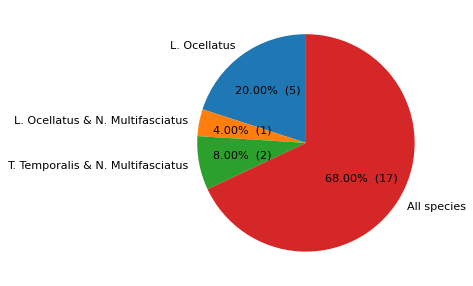

In [8]:
import matplotlib.pyplot as plt

# make the pie circular by setting the aspect ratio to 1
plt.figure(figsize=(10, 5))
nur_o = 5
om = 1
mt = 2
rest = 17
values = [nur_o, om, mt, rest]
labels = ["L. Ocellatus","L. Ocellatus & N. Multifasciatus", "T. Temporalis & N. Multifasciatus", "All species" ]

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct

plt.pie(values, labels=labels, autopct=make_autopct(values), startangle=90, textprops = dict(size=11.2))

plt.show()

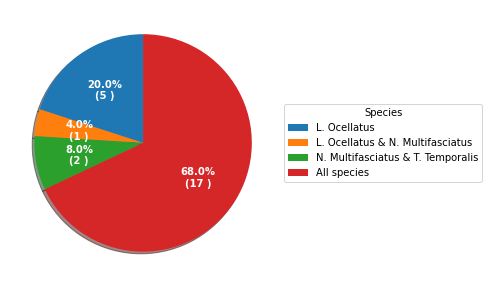

In [9]:
import numpy as np
fig, ax = plt.subplots(figsize=(10, 5), subplot_kw=dict(aspect="equal"))

recipe = ["5 L. Ocellatus",
          "1 L. Ocellatus & N. Multifasciatus",
          "2 N. Multifasciatus & T. Temporalis",
          "17 All species"]

data = [float(x.split()[0]) for x in recipe]
ingredients = [x.split()[1:] for x in recipe]
ingredients[2] = ' '.join(ingredients[2])
ingredients[3] = ' '.join(ingredients[3])
ingredients[1] = ' '.join(ingredients[1])
ingredients[0] = ' '.join(ingredients[0])
 
def func(pct, allvals):
    absolute = int(round(pct/100.*np.sum(allvals)))
    return "{:.1f}%\n({:d} )".format(pct, absolute)


wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="w"), startangle = 90, shadow=True)

ax.legend(wedges, ingredients,
          title="Species",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(autotexts, size=10, weight="bold")

plt.show()

In [10]:



oce = listdir_fullpath("/Users/nicol/Desktop/bachelorthesis/data/0o/")
tem = listdir_fullpath("/Users/nicol/Desktop/bachelorthesis/data/0t/")
mul = listdir_fullpath("/Users/nicol/Desktop/bachelorthesis/data/0m/")

oce_sizes = []
tem_sizes = []
mul_sizes = []

for elem in oce:
    df = pd.read_excel(elem)
    df = df.iloc[14:]
    df.columns = df.iloc[0]
    df = df.iloc[1:]
    oce_sizes.append(len(df))
    
for elem in tem:
    df = pd.read_excel(elem)
    df = df.iloc[14:]
    df.columns = df.iloc[0]
    df = df.iloc[1:]
    tem_sizes.append(len(df))

for elem in mul:
    df = pd.read_excel(elem)
    df = df.iloc[14:]
    df.columns = df.iloc[0]
    df = df.iloc[1:]
    mul_sizes.append(len(df))
    




In [11]:
oce_sizes, tem_sizes, mul_sizes

([180, 360, 194, 134, 198, 114, 178, 120, 138, 138],
 [418, 126, 182, 212],
 [460, 734, 548, 1402, 1150, 258, 614])

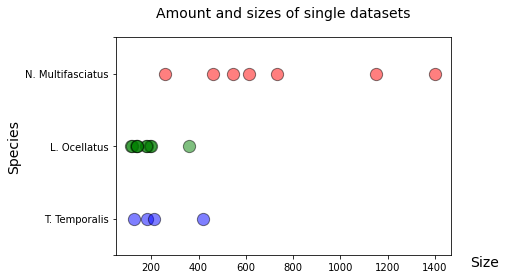

In [84]:


fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(y=[2]*10, x=oce_sizes, c='green', alpha=0.5, s=150, edgecolor='black')
ax1.scatter(y=[3]*7, x=mul_sizes, c='red', alpha=0.5, s=150, edgecolor='black')
ax1.scatter(y=[1]*4, x=tem_sizes, c='blue', alpha=0.5, s=150, edgecolor='black')
#ax1.annotate('Species', xy=(0, 1), xytext=(-50,20), ha='left', va='top', xycoords='axes fraction', textcoords='offset points', fontsize=13)
ax1.annotate('Size', xy=(0.98, 0), xytext=(1.06,0), ha='left', va='top', xycoords='axes fraction', fontsize=14)
plt.yticks([0.5,1,2,3,3.5], labels = ['','T. Temporalis' ,'L. Ocellatus', 'N. Multifasciatus',''])
plt.title('Amount and sizes of single datasets', size=14, pad=20)
plt.ylabel('Species', size=14)
plt.show()

# results

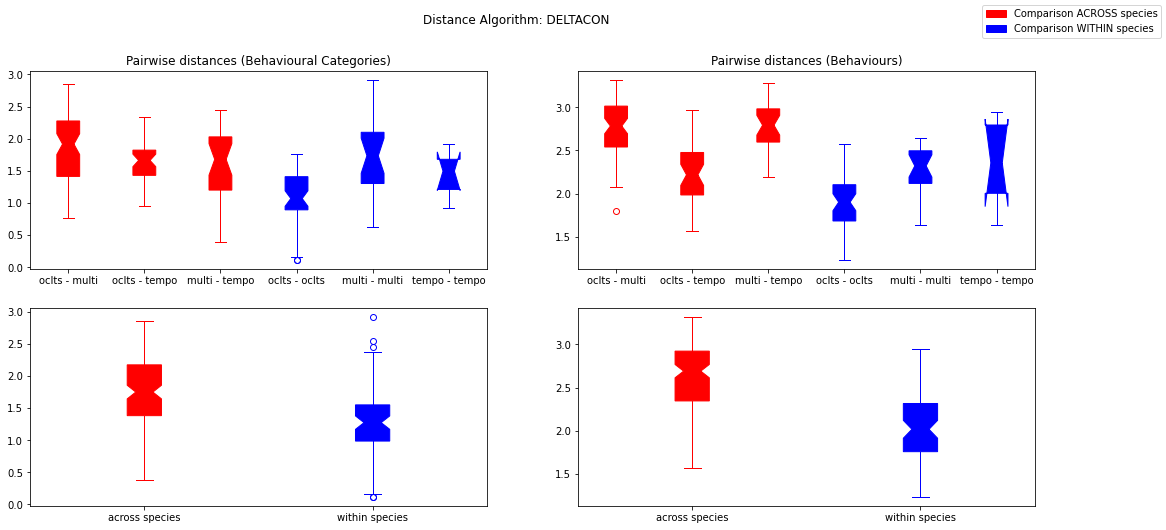

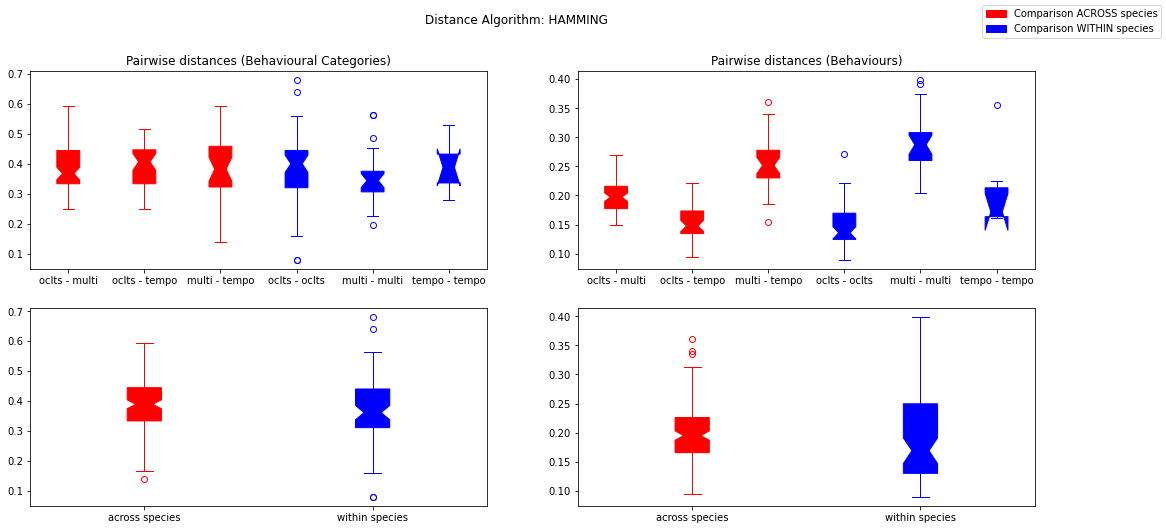

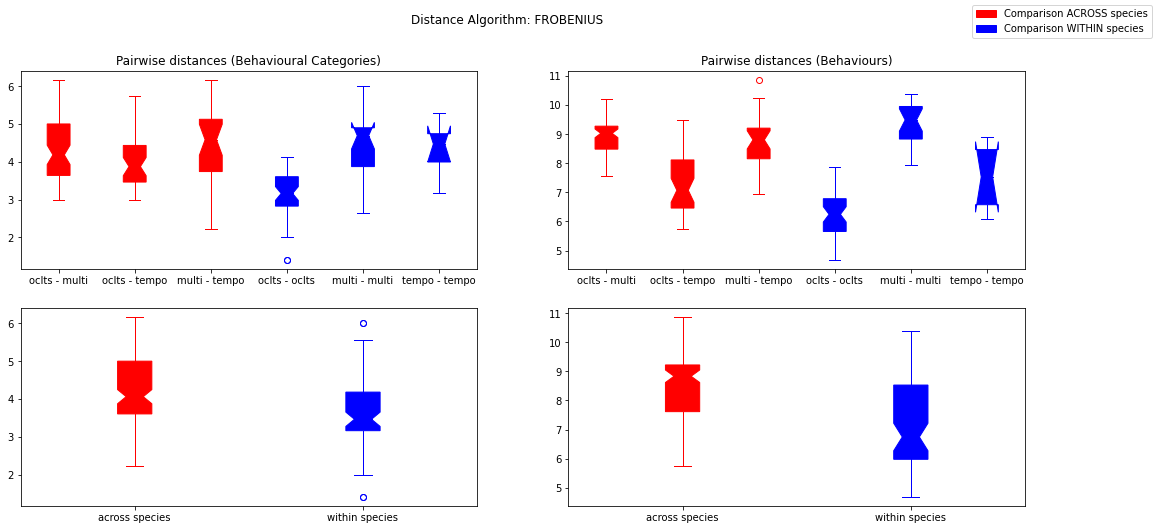

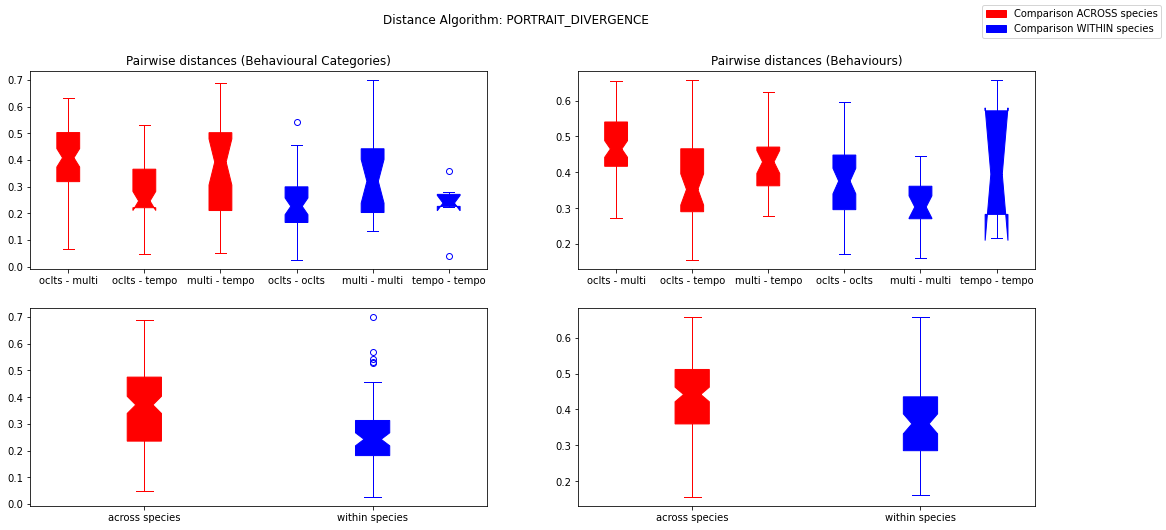

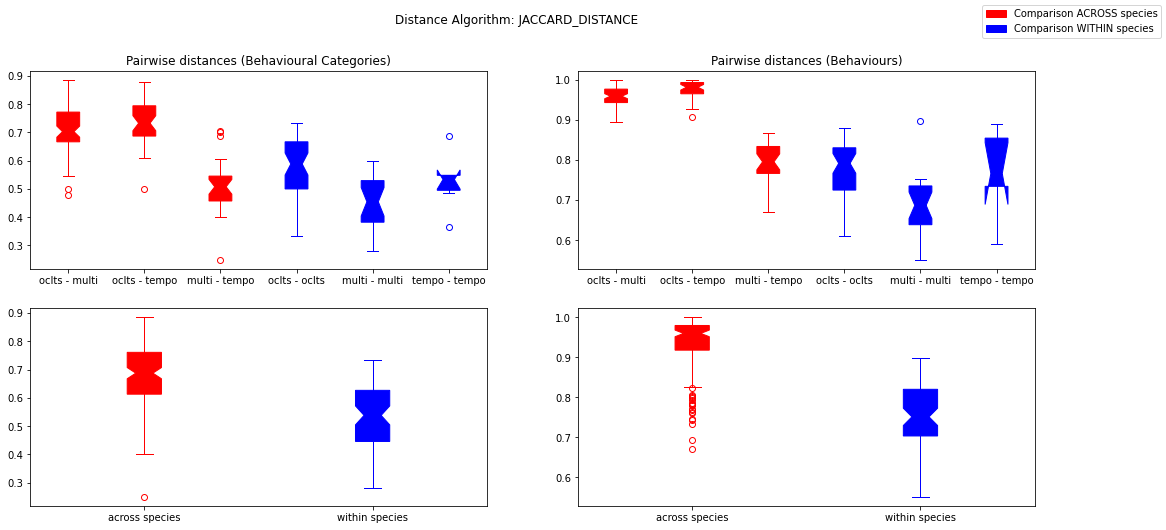

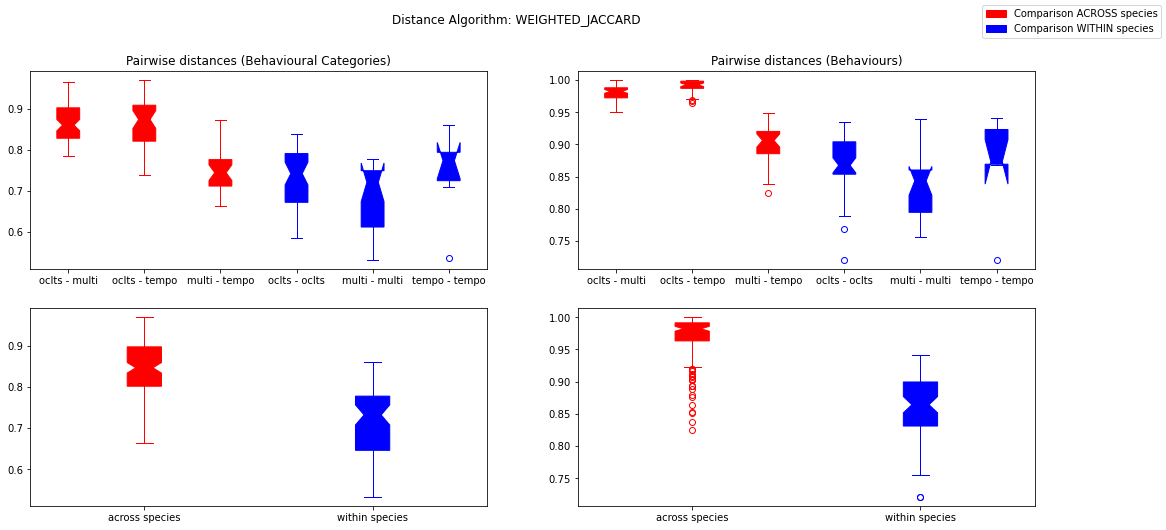

In [11]:
import matplotlib.patches as mpatches


for alg in algs:
    alg_df = df[df.alg == alg]
    
    #behavioural category data gen
    bhvr_df = alg_df[alg_df.type == 'behavioural category']
    data = []
    labels = []
    i=0
    while (i < len(bhvr_df)):
        data.append(bhvr_df.iloc[i]['results'])
        labels.append(bhvr_df.iloc[i]['data1'] + " - " +bhvr_df.iloc[i]['data2'])
        i = i+1
        
    #behaviour data gen
    bhvr_df = alg_df[alg_df.type == 'behaviour']
    data_bhvr = []
    labels_bhvr = []
    i=0
    while (i < len(bhvr_df)):
        data_bhvr.append(bhvr_df.iloc[i]['results'])
        labels_bhvr.append(bhvr_df.iloc[i]['data1'] + " - " +bhvr_df.iloc[i]['data2'])
        i = i+1
        
       
    #behavioural category plot
    c = 'red'
    fig, axs = plt.subplots(2,2, figsize=(18,8))
    axs[0,0].boxplot(data[:3], positions=[1,2,3], notch=True, patch_artist=True,
            boxprops=dict(facecolor=c, color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c),
            )
    c='blue'
    axs[0,0].boxplot(data[3:], positions=[4,5,6], notch=True, patch_artist=True,
            boxprops=dict(facecolor=c, color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c),
            )
    axs[0,0].set_title('Pairwise distances (Behavioural Categories)')
    axs[0,0].set_xticklabels(labels)
    
    #behaviour plot
    c = 'red'
    axs[0,1].boxplot(data_bhvr[:3], positions=[1,2,3], notch=True, patch_artist=True,
            boxprops=dict(facecolor=c, color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c),
            )
    c='blue'
    axs[0,1].boxplot(data_bhvr[3:], positions=[4,5,6], notch=True, patch_artist=True,
            boxprops=dict(facecolor=c, color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c),
            
            )
    axs[0,1].set_title('Pairwise distances (Behaviours)')
    axs[0,1].set_xticklabels(labels_bhvr)
    
    #title
    fig.suptitle("Distance Algorithm: " + alg.upper())
    
    
    
    
    
# generalized data plots below normal data

    alg_df = general_df[general_df.alg == alg]

    #behavioural category data gen
    bhvr_df = alg_df[alg_df.type == 'behavioural category']
    data = []
    labels = []
    i=0
    while (i < len(bhvr_df)):
        data.append(bhvr_df.iloc[i]['results'])
        labels.append(bhvr_df.iloc[i]['data'])
        i = i+1

    #behaviour data gen
    bhvr_df = alg_df[alg_df.type == 'behaviours']
    data_bhvr = []
    labels_bhvr = []
    i=0
    while (i < len(bhvr_df)):
        data_bhvr.append(bhvr_df.iloc[i]['results'])
        labels_bhvr.append(bhvr_df.iloc[i]['data'])
        i = i+1

       
    #behavioural category plot
    c = 'red'
    axs[1,0].boxplot(data[:1], positions=[1], notch=True, patch_artist=True,
            boxprops=dict(facecolor=c, color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c),
            )
    c='blue'
    axs[1,0].boxplot(data[1:], positions=[2], notch=True, patch_artist=True,
            boxprops=dict(facecolor=c, color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c),
            )
    axs[1,0].set_xticklabels(labels)
    
    
    #general behaviour plot
    c = 'red'
    axs[1,1].boxplot(data_bhvr[:1], positions=[1], notch=True, patch_artist=True,
            boxprops=dict(facecolor=c, color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c),
            )
    c='blue'
    axs[1,1].boxplot(data_bhvr[1:], positions=[2], notch=True, patch_artist=True,
            boxprops=dict(facecolor=c, color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c),
            )
   
    axs[1,1].set_xticklabels(labels_bhvr)

    
    
    
    # Adding title and legend
    red_patch = mpatches.Patch(color='red', label='Comparison ACROSS species')
    blue_patch = mpatches.Patch(color='blue', label='Comparison WITHIN species')
    fig.legend(handles=[red_patch, blue_patch])
    # show plot
    plt.show()
    



In [43]:
g2.edges

OutEdgeView([('Affiliative behavior', 'Maintenance'), ('Affiliative behavior', 'Restrained aggression'), ('Maintenance', 'Escape'), ('Maintenance', 'Maintenance'), ('Maintenance', 'Overt aggression'), ('Maintenance', 'Restrained aggression'), ('Maintenance', 'Submissive behavior'), ('Restrained aggression', 'Affiliative behavior'), ('Restrained aggression', 'Escape'), ('Restrained aggression', 'Maintenance'), ('Restrained aggression', 'Overt aggression'), ('Restrained aggression', 'Restrained aggression'), ('Escape', 'Escape'), ('Escape', 'Maintenance'), ('Escape', 'Overt aggression'), ('Escape', 'Restrained aggression'), ('Overt aggression', 'Escape'), ('Overt aggression', 'Maintenance'), ('Overt aggression', 'Restrained aggression'), ('Submissive behavior', 'Maintenance')])

In [45]:
g2[('Affiliative behavior', 'Maintenance')]

KeyError: ('Affiliative behavior', 'Maintenance')